# Homography transform practice 

Homography - mathematical transformation that maps points in one plane to points in another plane

Goal: accomplish this with ground plane points for a COLMAP cloud

Create a top-down cloud of the SfM generated cloud 

To be used for satellite matching 

FIRST: Transform COLMAP coordinates to a reference image frame of my choosing 

CHECKLIST

- Get pose 1 with known points on the ground plane
- Get points from that recognized pose 
- Choose a reference camera location
- Get a translation and rotation for that camera location
- Perform matrix math on each point in COLMAP --> translate to ref coordinates
- Plot asterisk to confirm same location

In [1]:
import numpy as np
import cv2
from skimage import *
from skimage import feature
import math
import matplotlib.pyplot as plt
import copy
import imageio


from colmapParsingUtils import *
from ptCloudParsingUtils import *


from scipy.spatial.distance import euclidean
from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog

%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


### NOTE: for coord frames

- RED: X-direction --> points positive
- GREEN: Y-direction --> points positive
- BLUE: Z-direction --> points positive

### Load point cloud data 

In [2]:
# # Scene: Tufts Turf Scene (generated by COLMAP with personal photos)
# imagedata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/images.txt"
# cameradata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/cameras.txt"
# pointdata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/points3D.txt"
# images_colmap = read_images_text('/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/images.txt')
# cameras = read_cameras_text('/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/cameras.txt')
# pts3d = read_points3D_text('/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/points3D.txt')

# Scene: Tufts Walkway Scene (generated by COLMAP with personal photos)
imagedata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/images.txt"
cameradata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/cameras.txt"
pointdata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/points3D.txt"
images_colmap = read_images_text('/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/images.txt')
cameras = read_cameras_text('/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/cameras.txt')
pts3d = read_points3D_text('/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/points3D.txt')

In [3]:
# print(images_colmap)
# print(cameras)
print(pts3d[56027])
print(len(pts3d))

raw_pts = [value.xyz for value in pts3d.values()]
raw_pts1 = [pts3d[key].xyz for key in pts3d.keys()]
raw_pts_rgb = [pts3d[key].rgb for key in pts3d.keys()]

# Convert to a 3-by-x NumPy array
scene_pts = np.vstack(raw_pts)
scene_pts1 = np.vstack(raw_pts1)

rgb_data = np.vstack(raw_pts_rgb)
# print(rgb_data)
rgb_data = rgb_data/255

# print(scene_pts)
# print(scene_pts1)
print(rgb_data)

# print(len(rgb_data))
# print(len(scene_pts))

Point3D(id=56027, xyz=array([ 0.22837523, -0.48802787, -2.43451632]), rgb=array([187, 204, 228]), error=1.2043676268214778, image_ids=array([46, 40]), point2D_idxs=array([2200,  117]))
43982
[[0.43137255 0.41568627 0.38431373]
 [0.16078431 0.16078431 0.04705882]
 [0.28235294 0.34509804 0.16862745]
 ...
 [0.64705882 0.64313725 0.63529412]
 [0.6        0.59607843 0.58823529]
 [0.69411765 0.6745098  0.51372549]]


pts3D
- point id number
- xyz position (in relation to colmap coordinates
- rgb value
- Reprojection error
- image_ids: Which images the point was observed in
- point2D_idxs: The 2D feature matches (same length as image_ids)
    - An index into the list of detected 2D keypoints in a specific image
    - Features like corners, edges, or interested points

In [4]:
# # Extract 3d points from raw file 

# # pointdata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/points3D.txt"
# pointdata_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/points3D.txt"

# num_pts = len(pts3d) # Gerrard Hall
# # print(pointdata_fn)
# # points_data = []
# scene_pts = np.zeros([num_pts, 3]) 
# idx = 0

# with open(pointdata_fn, 'r') as file:
#     lines = file.readlines()[3:]  # Skip the first three lines
    
#     for line in lines:
#         elements = line.strip().split()
        
#         row = [float(elem) for elem in list(elements)]

#         scene_pts[idx,0] = row[1]
#         scene_pts[idx,1] = row[2]
#         scene_pts[idx,2] = row[3]
#         idx += 1

# # Filter RGB data into separate numpy array 
# rgb_data = np.zeros([num_pts, 3])
# idx = 0

# with open(pointdata_fn, 'r') as file:
#     lines = file.readlines()[3:] # Skip the first three lines 
#     for line in lines:
#         elements = line.strip().split()
#         row = [float(elem) for elem in list(elements)]

#         rgb_data[idx,0] = row[4]
#         rgb_data[idx,1] = row[5]
#         rgb_data[idx,2] = row[6]
#         idx += 1

# # SCALE COLORS
# rgb_data = rgb_data/255
# # print(scene_pts[:10])

# # Filter RGB data into separate numpy array with ALPHA
# rgba_data = np.zeros([num_pts, 4])
# idx = 0

# with open(pointdata_fn, 'r') as file:
#     lines = file.readlines()[3:] # Skip the first three lines 
#     for line in lines:
#         elements = line.strip().split()
#         row = [float(elem) for elem in list(elements)]

#         rgba_data[idx,0] = row[4]
#         rgba_data[idx,1] = row[5]
#         rgba_data[idx,2] = row[6]
#         rgba_data[idx,3] = .5
#         idx += 1

# # SCALE COLORS
# # rgba_data = rgba_data/255
# rgba_data[:, :3] = rgba_data[:, :3] / 255
# # print(scene_pts[:10])
# print(scene_pts[:43983, :])

# Get camera poses 

In [5]:
# Convert COLMAP poses (xyz,quats) to rotm

# Ceate an empty array for camera poses as 4x4 transformation matrixes
poses = np.zeros([len(images_colmap),4,4])
# Create an empty array for image data, for 250x250 pixels 
images = np.zeros([len(poses),250,250,3])


skip_indices = {10, 17, 65, 83, 84}  # Use a set to store the indices to skip

#loop through <images_from_colmap> to get 3D poses of cameras at each timestamp
# print(len(images_colmap))
for n in range(len(images_colmap)):
    # print(n)
    if n in skip_indices:
        continue


    # Pull quaternion and translation vector
    qvec = images_colmap[n+1].qvec #raw
    # print(qvec)
    # print(images_colmap[n+1].tvec)
    tvec = images_colmap[n+1].tvec[:,None]
    # print(tvec)
    
    t = tvec.reshape([3,1])
    # print(tvec)
    Rotmat = qvec2rotmat(-qvec)
    print("\n Rotation matrix \n", Rotmat)
    Rotmat2 = qvec2rotmat(qvec)
    print("\n Rotation matrix2 \n", Rotmat2)

    
    bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
    # m represents world-to-camera transformation 
    # c2w represents camera-to-world transformation 
    m = np.concatenate([np.concatenate([Rotmat, t], 1), bottom], 0)
    c2w = np.linalg.inv(m)

    # NERF SPECIFIC ROTATIONS 
    # c2w[0:3,2] *= -1 # flip the y and z axis
    # c2w[0:3,1] *= -1
    # c2w = c2w[[1,0,2,3],:]
    # c2w[2,:] *= -1 # flip whole world upside down
    


    poses[n] = c2w
    # if n == 5:
    #     print(c2w)
        
    # poses[n] = m
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#GET REST OF PARAMS NEEDED FOR tinyNeRF format~~~~~~~~~~~~~~~~~~~~~~~~~~~~    

#fix order of colors
images[:,:,:,0], images[:,:,:,1] = images[:,:,:,1], images[:,:,:,0]

H,W = images.shape[1:3]
# print(H,W)
testimg, testpose = images[55], poses[55]

focal = cameras[1].params[0] #test- see if same focal length can be shared across all images
focal1 = focal/12
print(focal)
# print(poses)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# print(poses[5])


 Rotation matrix 
 [[ 0.97951901  0.10862608  0.16953726]
 [-0.15727653  0.9385059   0.30736096]
 [-0.1257243  -0.32773014  0.93636871]]

 Rotation matrix2 
 [[ 0.97951901  0.10862608  0.16953726]
 [-0.15727653  0.9385059   0.30736096]
 [-0.1257243  -0.32773014  0.93636871]]

 Rotation matrix 
 [[ 0.98278875  0.09201943  0.16018331]
 [-0.13578864  0.9477506   0.28866978]
 [-0.1252506  -0.30545249  0.94393382]]

 Rotation matrix2 
 [[ 0.98278875  0.09201943  0.16018331]
 [-0.13578864  0.9477506   0.28866978]
 [-0.1252506  -0.30545249  0.94393382]]

 Rotation matrix 
 [[ 0.98217394  0.09603773  0.16158929]
 [-0.14004436  0.94726535  0.28822895]
 [-0.12538708 -0.30572063  0.94382889]]

 Rotation matrix2 
 [[ 0.98217394  0.09603773  0.16158929]
 [-0.14004436  0.94726535  0.28822895]
 [-0.12538708 -0.30572063  0.94382889]]

 Rotation matrix 
 [[ 0.98858845  0.0889597   0.12156911]
 [-0.11910718  0.9556802   0.26923752]
 [-0.0922299  -0.28064486  0.95537014]]

 Rotation matrix2 
 [[ 0.98858

## CALCULATE FOCAL LENGTH 

- f_mm = focal length in mm
- f_pix = focal length in pixel 
- w_sensor = physical width of the camera sensor in millimeters (camera specs)
- w_image = width of the image in pixels (horizontal resolution)

f_mm = (f_pix x w_sensor) / w_im

# Plotting point cloud with origin

In [6]:
# Plotting 3D points
# BY ITSELF
# Data generated by COLMAP

vis = o3d.visualization.Visualizer()
vis.create_window()

# Add coordinate axes
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)


scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgba_data)

# Add necessary geometries
vis.add_geometry(axis_origin)
vis.add_geometry(scene_cloud)

# render_option = vis.get_render_option()
# render_option.point_size = 2

# Run visualization 
vis.run()
vis.destroy_window()


libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


# Plotting point cloud with camera poses 

In [7]:
# Create Open3D visualizer object
vis = o3d.visualization.Visualizer()
vis.create_window(window_name='3D Plot with Pose Axes and Point Cloud', width=1000, height=1000)

# Add coordinate axes
axis_orig = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.25)
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

# loop through poses 
for pose in poses:
    homog_t = pose
    axes1 = copy.deepcopy(axes).transform(homog_t)
    vis.add_geometry(axes1)
    

vis.add_geometry(axis_orig)
vis.add_geometry(scene_cloud)

# render_option = vis.get_render_option()
# render_option.point_size = 2

# Run the visualizer
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


# Choosing a specific image 

In [8]:
# Choose an image id
image_id = 40
# Gather 3d point ids from image data 
im_Ids_o = images_colmap[image_id].point3D_ids
print(images_colmap[image_id])
# print(im_Ids_o)
# print(im_Ids_o[1])
# Loop through and remove null 3d Ids
im_Ids = []
for i in range(len(im_Ids_o)):
    if im_Ids_o[i] > 0:
        im_Ids.append(im_Ids_o[i])

# print(im_Ids)
# Gather xyz points for each 3d point ID
camera_pts_xyz = np.zeros((len(im_Ids),3))
camera_pts_rgb = np.zeros((len(im_Ids),3))
# print(len(camera_pts_xyz))
# print(len(im_Ids))
for i in range(len(im_Ids)):
    # print(im_Ids[i])
    camera_pts_xyz[i] = pts3d[im_Ids[i]].xyz
    camera_pts_rgb[i] = pts3d[im_Ids[i]].rgb
    # print(pts3d[im_Ids[i]].rgb)

# Get camera pose for chosen image 
def get_pose_id(id):
    qvec = images_colmap[id].qvec
    tvec = images_colmap[id].tvec[:,None]
    # print(tvec)
    
    t = tvec.reshape([3,1])
    # print(tvec)
    Rotmat = qvec2rotmat(qvec) # Positive or negative does not matter
    # print("\n Rotation matrix \n", Rotmat)
    
    bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
    m = np.concatenate([np.concatenate([Rotmat, t], 1), bottom], 0)
    c2w = np.linalg.inv(m)
    return c2w

# Normalize colors 
camera_pts_rgb = camera_pts_rgb/255

homog_t = get_pose_id(image_id)
# print(homog_t)
rotation_m = homog_t[:3,:3]
# print(rotation_m)
# Gather translation vector 
trans_v = homog_t[:3,-1]
# print(trans_v)
size = 1

# print(camera_pts_xyz)
# print(pts3d[im_Ids[0]].xyz)
# print(pts3d[26358].xyz)
# print(len(images_colmap))
# print(len(images_colmap[1].point3D_ids))

Image(id=40, qvec=array([ 0.99796341, -0.04076268,  0.00363511, -0.04893077]), tvec=array([-0.93675265,  0.1078029 ,  3.77491174]), camera_id=1, name='IMG_7947.JPEG', xys=array([[1484.99780273,    7.7499361 ],
       [ 493.11837769,    9.91951847],
       [ 524.31793213,   12.77149773],
       ...,
       [2914.16845703, 2467.22973633],
       [2523.42797852,  909.09338379],
       [ 440.02410889, 1147.43237305]]), point3D_ids=array([   -1,    -1,    -1, ...,    -1, 56025,    -1]))


In [9]:
# Plotting points with regular point cloud 

vis = o3d.visualization.Visualizer()
vis.create_window(window_name='3D points from specified image id', width=1000, height=1000)

# Create initial axes 
axis_orig = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=np.array([0.,0.,0]))
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25, origin = np.array([0.,0.,0.])).transform(homog_t)

# axes = axes.transform(homog_t)

camera_specific = o3d.geometry.PointCloud()
camera_specific.points = o3d.utility.Vector3dVector(camera_pts_xyz)
camera_specific.paint_uniform_color([0, 0, 1])



vis.add_geometry(axis_orig)
vis.add_geometry(axes)
vis.add_geometry(scene_cloud)
# vis.add_geometry(camera_specific)


render_option = vis.get_render_option()
render_option.point_size = 1


# render_option.background_color = [1, 1, 1] #[0.678, 0.847, 0.902] # Light blue

vis.run()

vis.destroy_window()


libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [10]:
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name='3D points from specified image id', width=1000, height=1000)

# # Create initial axes 
# axis_orig = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=np.array([0.,0.,0]))
# axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25, origin = np.array([0.,0.,0.])).transform(homog_t)


# vis.add_geometry(axis_orig)

# # Capture frames for GIF
# frames = []
# num_frames = 250  # Adjust the number of frames

# for i in range(num_frames):
#     vis.update_geometry(axis_orig)
#     vis.poll_events()
#     vis.update_renderer()

#     # Capture current view
#     image = vis.capture_screen_float_buffer(False)
#     # Convert to 8-bit (0-255) and store the frame
#     image_8bit = (np.asarray(image) * 255).astype(np.uint8)
#     frames.append(image_8bit)

# # Create GIF
# imageio.mimsave('coordframe.gif', frames, duration=0.1)  # Adjust duration for frame rate


# vis.run()
# vis.destroy_window()


# Transform colmap coordinates to relative camera coordinates 

Inverse of a Homogeneous Transformation Matrix

A homogeneous transformation matrix T = \begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}

Steps to Compute \( T^{-1} \)
1. R^{-1} = R^T

2. Multiply negative of the translation vector \( t \) by \( R^T \):  
   t' = -R^T t

3. Form the new homogeneous transformation matrix: 
   Combine the results into a new homogeneous transformation matrix:
   \[
   T^{-1} = \begin{bmatrix}
   R^T & -R^T t \\
   0 & 1
   \end{bmatrix}


Example
If T = \begin{bmatrix}
\cos\theta & -\sin\theta & tx \\
\sin\theta & \cos\theta & ty \\
0 & 0 & 1
\end{bmatrix}

then T^{-1} = \begin{bmatrix}
\cos\theta & \sin\theta & -tx\cos\theta - ty\sin\theta \\
-\sin\theta & \cos\theta & tx\sin\theta - ty\cos\theta \\
0 & 0 & 1 
\end{bmatrix}.

In [11]:
def inv_homog_transform(homog):
    """ Inverting a homogeneous transformation matrix
    Inputs: homogeneous transformation matrix (4x4)
    Outputs: inverted 4x4 matrix
    """
    # Grab rotation matrix
    R = homog[:3,:3]
    print("\n R \n",R)
    # Transpose rotation matrix 
    R_inv = R.T
    print("\n Transpose of R \n",R_inv)
    # Grab translation matrix 
    t = homog[:-1, -1]
    t = t.reshape((3, 1))
    print("\n T \n",t)
    # - R_t * t
    t_inv = -R_inv @ t
    print("\n -R_t * T \n",t_inv)
    bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
    homog_inv = np.concatenate([np.concatenate([R_inv, t_inv], 1), bottom], 0)    
    print("\n Homogeneous new = \n", homog_inv)
    return homog_inv

print("Homogeneous transformation \n", homog_t)
homog_inv = inv_homog_transform(homog_t)
homog_inv_test = inv_homog_transform(homog_inv)
print("\n Negative Homogeneous transform \n", homog_inv_test)

Homogeneous transformation 
 [[ 9.95185130e-01 -9.79585997e-02 -3.26632264e-03  9.55132609e-01]
 [ 9.73658918e-02  9.91888367e-01 -8.17150572e-02  2.92746441e-01]
 [ 1.12445200e-02  8.10035814e-02  9.96650380e-01 -3.76046631e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 R 
 [[ 0.99518513 -0.0979586  -0.00326632]
 [ 0.09736589  0.99188837 -0.08171506]
 [ 0.01124452  0.08100358  0.99665038]]

 Transpose of R 
 [[ 0.99518513  0.09736589  0.01124452]
 [-0.0979586   0.99188837  0.08100358]
 [-0.00326632 -0.08171506  0.99665038]]

 T 
 [[ 0.95513261]
 [ 0.29274644]
 [-3.76046631]]

 -R_t * T 
 [[-0.93675265]
 [ 0.1078029 ]
 [ 3.77491174]]

 Homogeneous new = 
 [[ 9.95185130e-01  9.73658918e-02  1.12445200e-02 -9.36752650e-01]
 [-9.79585997e-02  9.91888367e-01  8.10035814e-02  1.07802903e-01]
 [-3.26632264e-03 -8.17150572e-02  9.96650380e-01  3.77491174e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 R 
 [[ 0.99518513  0.09736589  0.0112

In [12]:
# Re-establish necessary variables 
image_id = image_id
homog_t = get_pose_id(image_id)
print("Homog \n", homog_t)
print("\n Inverse \n", homog_inv)

# Inverse of homogeneous transformation to 

pts_transformed = np.zeros((len(camera_pts_xyz),3))

# Apply homogeneous transform for each point in cloud
print(camera_pts_xyz)

for i in range(len(camera_pts_xyz)):
    pt = camera_pts_xyz[i]
    # Change point from 3x1 to 4x1 for homogeneous transform 
    pt = np.append(pt, 1)
    # print("\n 4D point \n", pt)
    new_pt = homog_inv @ pt
    # new_pt = homog_t @ pt
    # print(new_pt)
    # Grab xyz coodinates of new point
    pt_t = new_pt[:3]
    print("\n new point \n", pt_t)
    pts_transformed[i] = pt_t


Homog 
 [[ 9.95185130e-01 -9.79585997e-02 -3.26632264e-03  9.55132609e-01]
 [ 9.73658918e-02  9.91888367e-01 -8.17150572e-02  2.92746441e-01]
 [ 1.12445200e-02  8.10035814e-02  9.96650380e-01 -3.76046631e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 Inverse 
 [[ 9.95185130e-01  9.73658918e-02  1.12445200e-02 -9.36752650e-01]
 [-9.79585997e-02  9.91888367e-01  8.10035814e-02  1.07802903e-01]
 [-3.26632264e-03 -8.17150572e-02  9.96650380e-01  3.77491174e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.22837523 -0.48802787 -2.43451632]
 [ 0.18567003 -0.51637226 -2.33835711]
 [ 0.24137813 -0.41947745 -2.45707688]
 ...
 [-1.62793234 -0.09502431  0.51277903]
 [ 0.87674574  0.09341337 -3.05017452]
 [ 3.06875232 -2.73556686  7.55315384]]

 new point 
 [-0.78436925 -0.59584213  1.3876834 ]

 new point 
 [-0.82854735 -0.61198401  1.48597617]

 new point 
 [-0.76500817 -0.53094899  1.35955434]

 new point 
 [-0.06039705 -0.18399177  0.4687

In [13]:
# PLOT NEW POINTS

vis = o3d.visualization.Visualizer()
vis.create_window()

# Add coordinate axes
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
# axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.25, origin = np.array([0.,0.,0.])).transform(homog_t)
axes1 = copy.deepcopy(axes).transform(homog_inv)

scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgba_data)

pts_old = o3d.geometry.PointCloud()
pts_old.points = o3d.utility.Vector3dVector(camera_pts_xyz)
pts_old.paint_uniform_color([0, 0, 1])
# pts_old.colors = o3d.utility.Vector3dVector(camera_pts_rgb)

pts_new = o3d.geometry.PointCloud()
pts_new.points = o3d.utility.Vector3dVector(pts_transformed)
pts_new.paint_uniform_color([1, 0, 0])
# pts_new.colors = o3d.utility.Vector3dVector(camera_pts_rgb)

# TROUBLESHOOTING - add a sphere
circle = o3d.geometry.TriangleMesh.create_sphere(radius = .1, resolution = 20) # 20 is the default
circle1 = o3d.geometry.TriangleMesh.create_sphere(radius = .1, resolution = 20).translate([0.,0.,1.]) # 20 is the default


# Add necessary geometries
# vis.add_geometry(axis_origin)
vis.add_geometry(axes)
vis.add_geometry(axes1)
vis.add_geometry(scene_cloud)
vis.add_geometry(pts_old)
vis.add_geometry(pts_new)
# vis.add_geometry(circle)
# vis.add_geometry(circle1)


# render_option = vis.get_render_option()
# render_option.point_size = 2

# Run visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [14]:
# Plot just 3D points with color 

vis = o3d.visualization.Visualizer()
vis.create_window()

# Add coordinate axes
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
# Add cloud 
pts_new = o3d.geometry.PointCloud()
pts_new.points = o3d.utility.Vector3dVector(pts_transformed)
# pts_new.paint_uniform_color([1, 0, 0])
pts_new.colors = o3d.utility.Vector3dVector(camera_pts_rgb)


# Add necessary geometries
vis.add_geometry(axis_origin)
vis.add_geometry(pts_new)



# render_option = vis.get_render_option()
# render_option.point_size = 2
# vis.poll_events()
# vis.update_renderer()

# # Set up initial viewpoint
# view_control = vis.get_view_control()
# # Direction which the camera is looking
# view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # Point which the camera revolves about 
# view_control.set_lookat([0, 0, 0])   # Set the focus point
# # Defines which way is up in the camera perspective 
# view_control.set_up([-1, 0, 0])       # Set the up direction
# view_control.set_zoom(.1)           # Adjust zoom if necessary


# # Capture frames for GIF
# frames = []
# num_frames = 30  # Adjust the number of frames
# angle_step = 180/num_frames

# for i in range(num_frames):
# 	# Rotate the view
#     view_control.rotate(angle_step, angle_step)  # (horizontal, vertical)

#     # vis.update_geometry(axis_orig) # Only if I move it myself?
#     vis.poll_events()
#     vis.update_renderer()

#     # Capture frame directly into memory
#     image = vis.capture_screen_float_buffer(False)
#     image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
#     frames.append(image_8bit)


# for i in range(num_frames):
# 	# Rotate the view
# 	view_control.rotate(-angle_step, -angle_step)  # (horizontal, vertical)

# 	# vis.update_geometry(axis_orig) # Only if I move it myself?
# 	vis.poll_events()
# 	vis.update_renderer()

# 	# Capture frame directly into memory
# 	image = vis.capture_screen_float_buffer(False)
# 	image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
# 	frames.append(image_8bit)

# for i in range(num_frames):
# 	# Rotate the view
# 	view_control.rotate(-angle_step, angle_step)  # (horizontal, vertical)

# 	# vis.update_geometry(axis_orig) # Only if I move it myself?
# 	vis.poll_events()
# 	vis.update_renderer()

# 	# Capture frame directly into memory
# 	image = vis.capture_screen_float_buffer(False)
# 	image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
# 	frames.append(image_8bit)

# for i in range(num_frames):
# 	# Rotate the view
# 	view_control.rotate(angle_step, -angle_step)  # (horizontal, vertical)

# 	# vis.update_geometry(axis_orig) # Only if I move it myself?
# 	vis.poll_events()
# 	vis.update_renderer()

# 	# Capture frame directly into memory
# 	image = vis.capture_screen_float_buffer(False)
# 	image_8bit = (np.asarray(image) * 255).astype(np.uint8)  # Convert to 8-bit
# 	frames.append(image_8bit)





# # Create GIF
# # Ensure frames are in the correct format
# frames = [frame.astype("uint8") for frame in frames]

# # Use imageio to save as GIF
# imageio.mimsave("cam40_pts.gif", frames, fps=30, loop=0)  # Adjust fps if necessary


vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


# Transform from 3d to 2d points

In [15]:
# Create new 2D point array

pts_2d = np.zeros((len(pts_transformed),3))

for i in range(len(pts_transformed)):
    pt = pts_transformed[i,:]
    # print(pt)
    x = pt[0]
    y = pt[1]
    z = pt[2]
    x_new = x/z
    # print(x_new)
    y_new = y/z
    # print(y_new)
    new_pt = np.array((x_new, y_new, 1))
    print(new_pt)
    pts_2d[i,:] = new_pt

print(pts_2d)

[-0.56523646 -0.42937901  1.        ]
[-0.55757781 -0.41183972  1.        ]
[-0.5626904  -0.39053165  1.        ]
[-0.12883641 -0.39248339  1.        ]
[ 0.10150715 -0.39049948  1.        ]
[-0.13793442 -0.38635382  1.        ]
[-0.04425943 -0.38184954  1.        ]
[ 0.12838091 -0.37925059  1.        ]
[ 0.04000321 -0.37209451  1.        ]
[-0.04153621 -0.37014376  1.        ]
[-0.04153621 -0.37014376  1.        ]
[-0.1100715  -0.36712335  1.        ]
[-0.11007615 -0.36717612  1.        ]
[-0.04868809 -0.35907501  1.        ]
[ 0.06516678 -0.3592732   1.        ]
[ 0.02423901 -0.35765084  1.        ]
[-0.01181138 -0.35658099  1.        ]
[-0.01893695 -0.35553027  1.        ]
[ 0.06338861 -0.34858878  1.        ]
[-0.16959428 -0.34178971  1.        ]
[-0.56022578 -0.33326146  1.        ]
[-0.560127   -0.33324333  1.        ]
[-0.13786005 -0.33495634  1.        ]
[-0.00310077 -0.33537824  1.        ]
[ 0.00931172 -0.33287474  1.        ]
[-0.17949286 -0.3300226   1.        ]
[-0.12014656

In [16]:
# PLOT NEW POINTS 

vis = o3d.visualization.Visualizer()
vis.create_window()

# Add coordinate axes
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.5)
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5).transform(homog_t)


cloud_2d = o3d.geometry.PointCloud()
cloud_2d.points = o3d.utility.Vector3dVector(pts_2d)
# cloud_2d.paint_uniform_color([0, 0, 1])
cloud_2d.colors = o3d.utility.Vector3dVector(camera_pts_rgb)

# Add necessary geometries
vis.add_geometry(axis_origin)
# vis.add_geometry(scene_cloud)
# vis.add_geometry(axes)
vis.add_geometry(cloud_2d)


# render_option = vis.get_render_option()
# render_option.point_size = 1
	

# Run visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 81
pci id for fd 81: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


# Plot 2D points on physical image

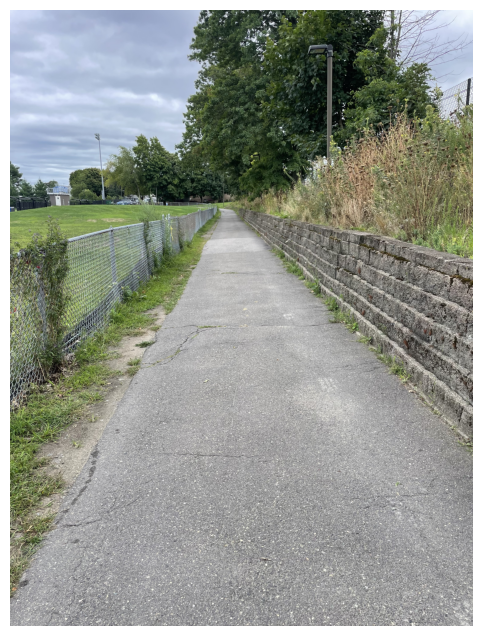

In [17]:
# Load in images
im_40 = cv2.imread('/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG')

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
image_rgb = cv2.cvtColor(im_40, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

# # Show image 
# # Can do with opencv, don't need open3d
# cv2.imshow('Resized Image', im_40)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

[-1702 -1679 -1694 ... -1793  -371   506]
[-1293 -1240 -1176 ...   150  -550  -600]


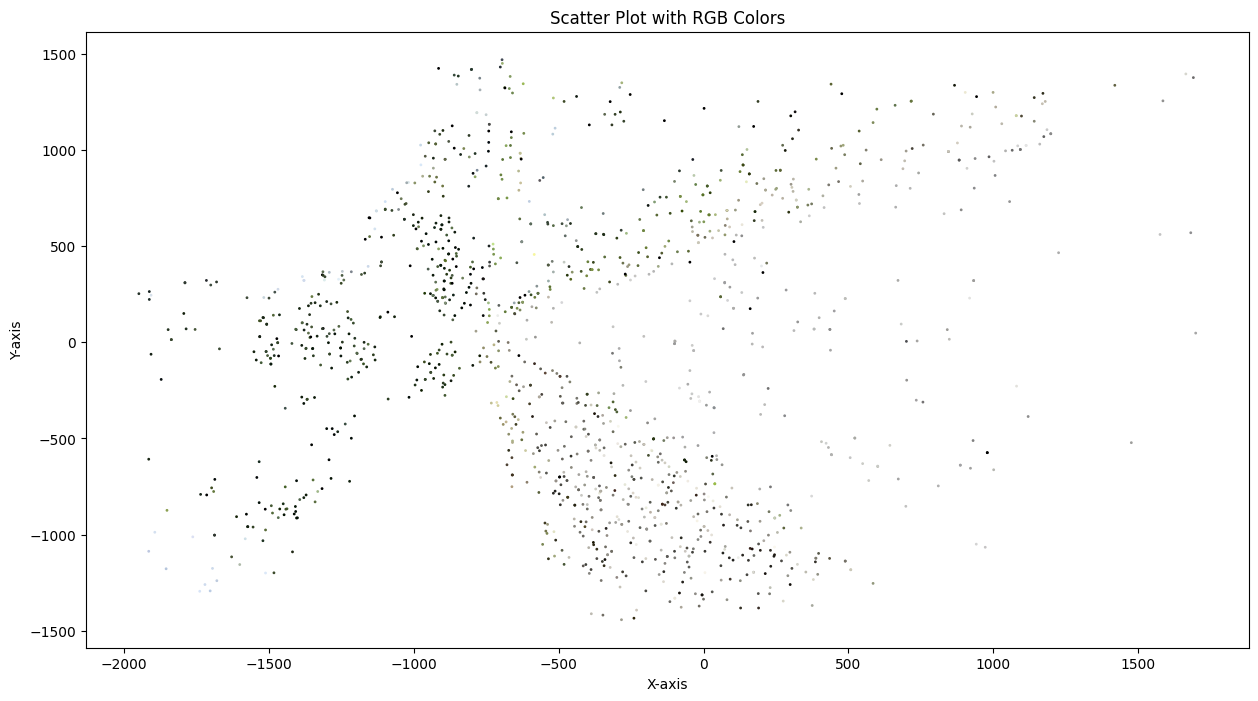

In [18]:
# Plot points without image
# plt.figure(figsize=(15,8))

x = pts_2d[:,0]
x = x*focal
x = x.astype(int)
print(x)
y = pts_2d[:,1]
y = y*focal
y = y.astype(int)
print(y)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the points with corresponding RGB colors
scatter = ax.scatter(x, y, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Scatter Plot with RGB Colors')

# Show the plot
plt.show()

In [19]:
print(im_40.shape)
print("\n Min x", min(x))
print("\n Max x", max(x))
print("\n Min y", min(y))
print("\n Max y", max(y))
print("\n Focal", focal)

(4032, 3024, 3)

 Min x -1948

 Max x 1698

 Min y -1443

 Max y 1470

 Focal 3011.9738700121015


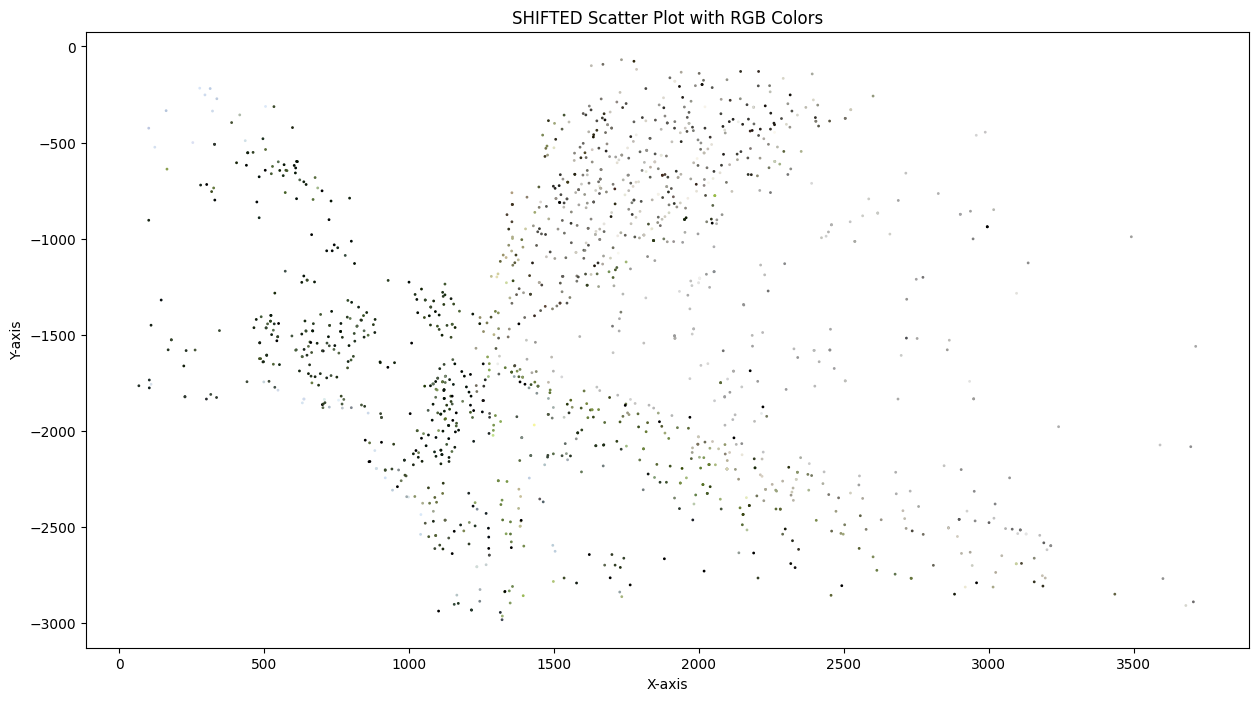

In [20]:
x_shift = x + 2016
# print(x_shift)
y_shift = y + 1512

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the points with corresponding RGB colors
scatter = ax.scatter(x_shift, -y_shift, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('SHIFTED Scatter Plot with RGB Colors')

# Show the plot
plt.show()

# Points plotted on top of image: SIMPLE SHIFT

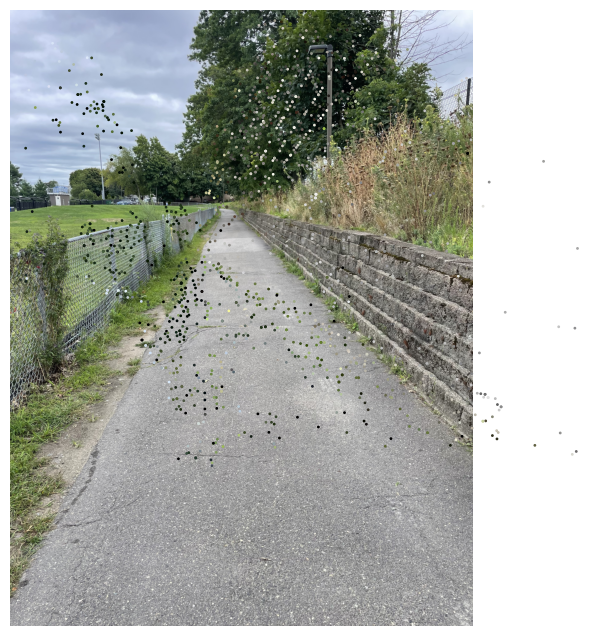

In [21]:
# Load in images
im_40 = cv2.imread('/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG')

image_rgb = cv2.cvtColor(im_40, cv2.COLOR_BGR2RGB)

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
plt.imshow(image_rgb)
# Plot the points with corresponding RGB colors
plt.scatter(x_shift, y_shift, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.axis("off")
plt.show()

# Points plotted on top of image: INVERTED Y SHIFT

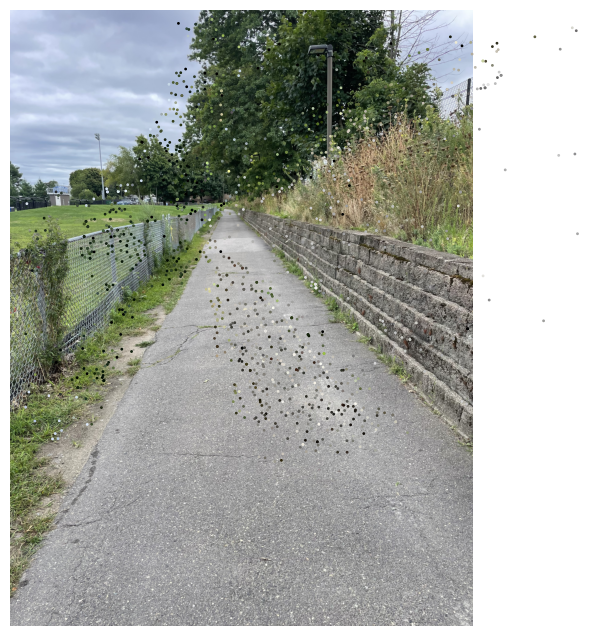

In [22]:
x_shift = x + 2016
# print(x_shift)
y_shift = y - 1512

# Load in images
im_40 = cv2.imread('/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG')

image_rgb = cv2.cvtColor(im_40, cv2.COLOR_BGR2RGB)

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
plt.imshow(image_rgb)
# Plot the points with corresponding RGB colors
plt.scatter(x_shift, -y_shift, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.axis("off")
plt.show()

# Points plotted on top of image: INVERTED X AND Y SHIFT

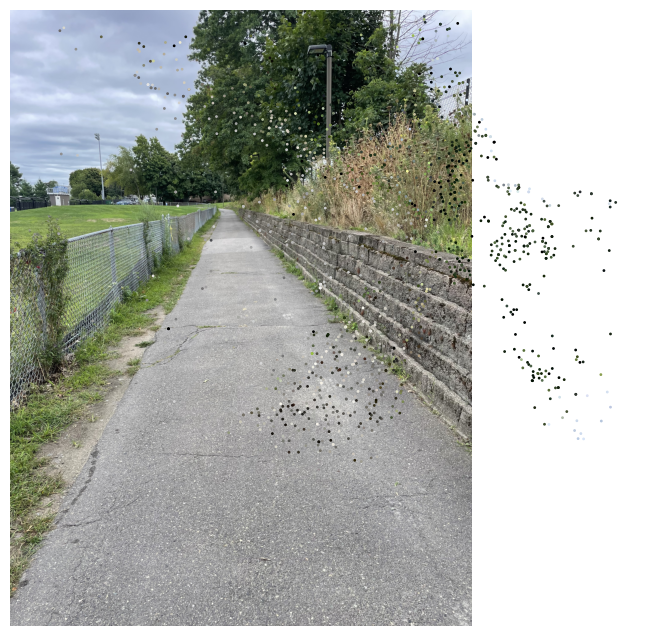

In [23]:
x_shift = x - 2016
# print(x_shift)
y_shift = y - 1512

# Load in images
im_40 = cv2.imread('/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG')

image_rgb = cv2.cvtColor(im_40, cv2.COLOR_BGR2RGB)

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
plt.imshow(image_rgb)
# Plot the points with corresponding RGB colors
plt.scatter(-x_shift, -y_shift, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.axis("off")
plt.show()

In [24]:
print(x_shift)
print(y_shift)

[-3718 -3695 -3710 ... -3809 -2387 -1510]
[-2805 -2752 -2688 ... -1362 -2062 -2112]


# Points plotted on top of image: CHANGE X AND Y, NO INVERSION

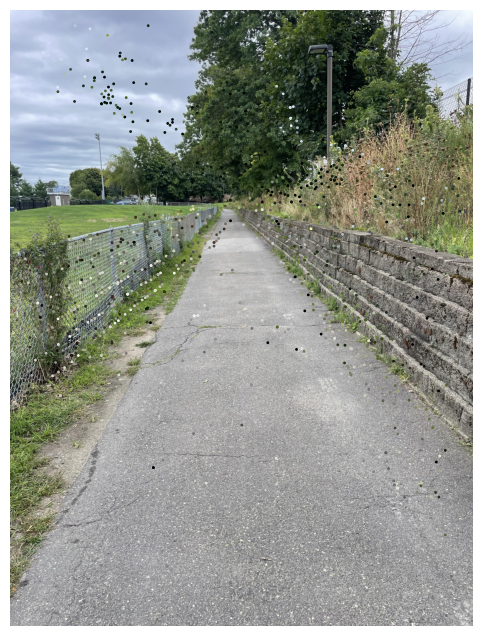

In [25]:
x_shift = x + 2016
# print(x_shift)
y_shift = y + 1512

# Load in images
im_40 = cv2.imread('/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG')

image_rgb = cv2.cvtColor(im_40, cv2.COLOR_BGR2RGB)

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
plt.imshow(image_rgb)
# Plot the points with corresponding RGB colors
plt.scatter(y_shift, x_shift, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size
plt.axis("off")
plt.show()

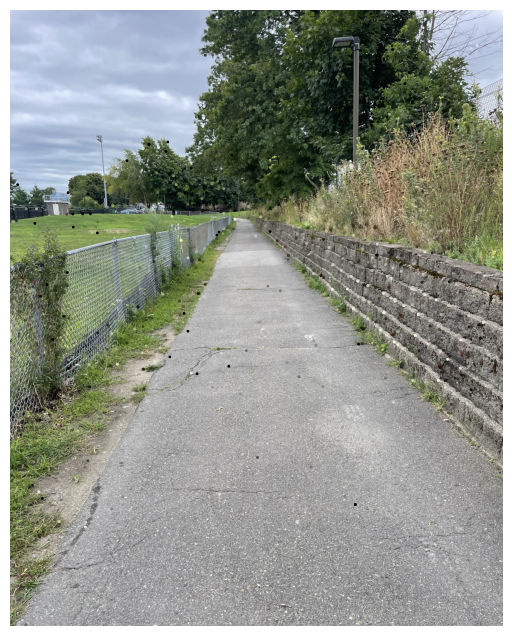

In [31]:
x_shift = x + 2016
# print(x_shift)
y_shift = y - 1512

# Load in images
im_40 = cv2.imread('/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG')

image_rgb = cv2.cvtColor(im_40, cv2.COLOR_BGR2RGB)

# Change coloring when moving from opencv to matplotlib 
plt.figure(figsize=(15, 8))
plt.imshow(image_rgb)
# Plot the points with corresponding RGB colors
plt.scatter(-y_shift, x_shift, c=camera_pts_rgb, s=1)  # 'c=rgb' assigns colors to points; 's' sets marker size



# Optionally, set axis limits for better viewing if needed
plt.xlim([min(-y_shift), max(-y_shift)])
plt.ylim([min(x_shift), max(x_shift)])

# Flip the y-axis to match the image's coordinate system
plt.gca().invert_yaxis()


plt.axis("off")
plt.show()